### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

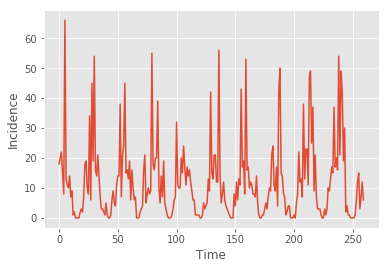

In [90]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

arr_list = np.zeros(260)
for s in range(10):
    for t in range(26):
        season_effect = np.random.choice([5,10,25], p = [0.2, 0.6, 0.2])
        e_y = season_effect*np.sin(10*(t+np.pi)/(13*np.pi)) + season_effect
        arr_list[(s-1)*26+t] = np.random.poisson(e_y) 
ts = arr_list[:100]
plt.xlabel("Time")
plt.ylabel("Incidence")
plt.plot(arr_list)
plt.show()

Suppose we have time-varying delay at time 80-100

In [91]:
p_vec = np.random.dirichlet(np.ones(10),size=1)[0]
print (p_vec)

[0.14932524 0.08642399 0.19757642 0.06676644 0.05568902 0.04802874
 0.03560358 0.17270884 0.01654278 0.17133496]


If the true delay distribution is given by 
$$p_1,...,p_{10} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

In [92]:
# we choose 10 data points to apply the partially observed mask to

data_to_be_delayed = ts[90:]
print (data_to_be_delayed)

[5. 3. 1. 0. 0. 0. 1. 3. 6. 7.]


In [93]:
tmp = []
count = 10
for y_t in data_to_be_delayed:
    tmp.append(y_t*sum(p_vec[:count]))
    count -=1
data_to_be_delayed = np.round(tmp)   
print (data_to_be_delayed)

# data to be delayed now contains the dirichlet proportions

[5. 2. 1. 0. 0. 0. 1. 1. 1. 1.]


In [94]:
delayed_data = np.append(ts[:90],data_to_be_delayed)

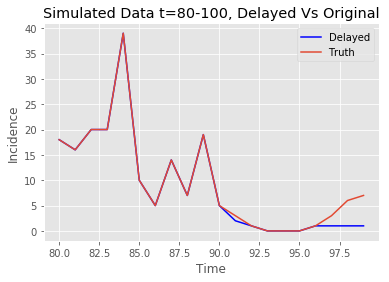

In [95]:
plt.plot(range(80,100),delayed_data[80:],color='b')
plt.plot(range(80,100),ts[80:])
plt.title("Simulated Data t=80-100, Delayed Vs Original")
plt.legend(("Delayed","Truth"))
plt.ylabel("Incidence")
plt.xlabel("Time")
plt.show()

In [96]:
print (ts)
print (delayed_data)

[18. 20. 22. 15.  8. 66. 13. 11. 10. 14.  7.  9.  1.  2.  0.  0.  0.  0.
  2.  3.  2.  7. 18. 19. 10.  8. 34.  6. 45. 19. 54. 16. 14. 21. 14.  7.
  3.  3.  2.  1.  5.  1.  0.  0.  1.  6.  9.  5.  4. 11. 14. 14. 38.  7.
 21. 24. 45. 15. 16. 13. 19.  6. 16. 10.  6.  7.  0.  0.  0.  2.  3.  4.
 16. 21.  5.  8. 10.  8.  9. 55. 18. 16. 20. 20. 39. 10.  5. 14.  7. 19.
  5.  3.  1.  0.  0.  0.  1.  3.  6.  7.]
[18. 20. 22. 15.  8. 66. 13. 11. 10. 14.  7.  9.  1.  2.  0.  0.  0.  0.
  2.  3.  2.  7. 18. 19. 10.  8. 34.  6. 45. 19. 54. 16. 14. 21. 14.  7.
  3.  3.  2.  1.  5.  1.  0.  0.  1.  6.  9.  5.  4. 11. 14. 14. 38.  7.
 21. 24. 45. 15. 16. 13. 19.  6. 16. 10.  6.  7.  0.  0.  0.  2.  3.  4.
 16. 21.  5.  8. 10.  8.  9. 55. 18. 16. 20. 20. 39. 10.  5. 14.  7. 19.
  5.  2.  1.  0.  0.  0.  1.  1.  1.  1.]


First suppose we have the true delay proportions. 
$$N_{t,\infty} | N_{t,d} \propto N_{t,d} | N_{t,\infty} \cdot N_{t,\infty}$$

In [97]:
n_t_d = data_to_be_delayed



Lets fit an $AR$-state space model of the form 
$$Y_t \sim N(X_t,\sigma_y^2)$$
$$X_t \sim N(\phi_1X_{t-1},\sigma_x^2)$$

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


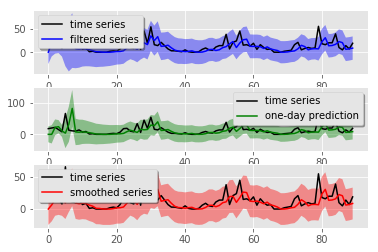

In [98]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(ts[:90])

myDLM = myDLM + autoReg(degree=2, data=ts[:90], name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)
myDLM.plot()

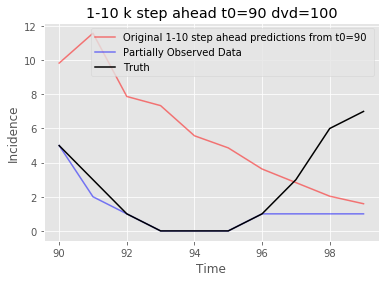

In [99]:
n_t_inf_hat = predictMean
plt.plot(range(90,100),n_t_inf_hat,color='r',alpha=.5)
plt.plot(range(90,100),data_to_be_delayed,color='b',alpha=.5)
plt.plot(range(90,100),ts[90:],color='black')
plt.title("1-10 k step ahead t0=90 dvd=100")
plt.legend(("Original 1-10 step ahead predictions from t0=90 ","Partially Observed Data","Truth"))
plt.xlabel("Time")
plt.ylabel("Incidence")
plt.show()

Finally we perform the re-weighting.

In [100]:
num_mc_samples = 1000
reweighted_trajectory = []
from  scipy.stats import binom
count = 10
for t in range(len(n_t_inf_hat)):
    likelihood_previous = -100000
    likelihood_current = -1000000
    tmp = 0
    for s in range(num_mc_samples):
        fcast = np.random.normal(n_t_inf_hat[t],np.sqrt(predictVar[t]))
        likelihood_current = binom.logpmf(data_to_be_delayed[t],fcast,sum(p_vec[:count])-.000000000001)
        #print (data_to_be_delayed[t],fcast,sum(p_vec[:count]),likelihood_current)
        if likelihood_current > likelihood_previous:           
            likelihood_previous = likelihood_current
            tmp = fcast
    #print (len(tmp))
    reweighted_trajectory.append(tmp)
    
    count -=1 

In [101]:
reweighted_trajectory

[5.014859724195638,
 2.0210547463008854,
 1.0187220155964578,
 0.05435140370179958,
 0.03353025248790775,
 0.04780351068055211,
 1.4543215207072575,
 1.7675639544063002,
 3.7075204198407268,
 6.181362534429491]

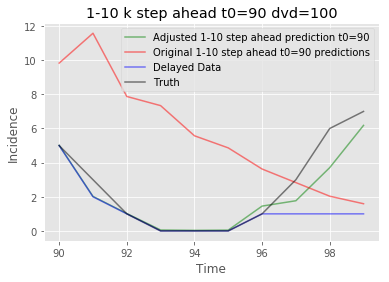

[]

In [102]:
plt.plot(range(90,100),reweighted_trajectory,color='g',alpha=.5)
plt.plot(range(90,100),n_t_inf_hat,color='r',alpha=.5)
plt.plot(range(90,100),data_to_be_delayed,color='b',alpha=.5)
plt.title("1-10 k step ahead t0=90 dvd=100")
plt.plot(range(90,100),ts[90:],color='black',alpha=.5)
plt.legend(('Adjusted 1-10 step ahead prediction t0=90','Original 1-10 step ahead t0=90 predictions','Delayed Data','Truth'))
plt.xlabel("Time")
plt.ylabel("Incidence")
plt.show()
plt.plot()

## Using nowcast to improve forecast




In [103]:

## get predictions for 90-100 from nowcast
new_training_data = np.nan_to_num(np.append(ts[:90],reweighted_trajectory))
myDLM = dlm(new_training_data)

myDLM = myDLM + autoReg(degree=2, data=new_training_data, name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMeanRetrain, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)



Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


In [104]:
ts

array([18., 20., 22., 15.,  8., 66., 13., 11., 10., 14.,  7.,  9.,  1.,
        2.,  0.,  0.,  0.,  0.,  2.,  3.,  2.,  7., 18., 19., 10.,  8.,
       34.,  6., 45., 19., 54., 16., 14., 21., 14.,  7.,  3.,  3.,  2.,
        1.,  5.,  1.,  0.,  0.,  1.,  6.,  9.,  5.,  4., 11., 14., 14.,
       38.,  7., 21., 24., 45., 15., 16., 13., 19.,  6., 16., 10.,  6.,
        7.,  0.,  0.,  0.,  2.,  3.,  4., 16., 21.,  5.,  8., 10.,  8.,
        9., 55., 18., 16., 20., 20., 39., 10.,  5., 14.,  7., 19.,  5.,
        3.,  1.,  0.,  0.,  0.,  1.,  3.,  6.,  7.])

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


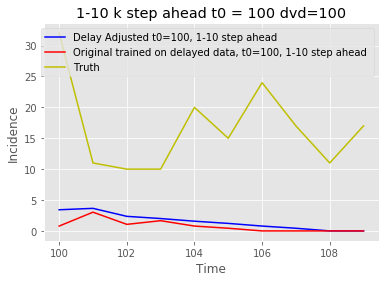

RETRAINED
121.99683517580748
ORIGINAL
133.39939170018675


In [105]:


from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(ts)

myDLM = myDLM + autoReg(degree=2, data=delayed_data, name='ar2', w=1.0)
myDLM.fit()
br =  myDLM.getMean(filterType='forwardFilter')
(predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)

from sklearn.metrics import mean_squared_error
plt.plot(range(100,110),predictMeanRetrain,color='b')
plt.plot(range(100,110),predictMean,color='r')
plt.plot(range(100,110),arr_list[100:110],color='y')
plt.title("1-10 k step ahead t0 = 100 dvd=100")
plt.legend(("Delay Adjusted t0=100, 1-10 step ahead ","Original trained on delayed data, t0=100, 1-10 step ahead ","Truth"))
plt.xlabel("Time")
plt.ylabel("Incidence")

plt.show()

print ("RETRAINED")
print (mean_squared_error(predictMeanRetrain,truth))
print ("ORIGINAL")
print (mean_squared_error(predictMean,truth))